In [65]:
import numpy as np
import pandas as pd
import random
from numpy.linalg import matrix_rank
import scipy
import scipy.stats
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA as SKPCA

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Introduction

This notebook is the self-assigned final project for a Coursera course that I took entitled *Mathematics for Machine Learning: PCA* during the Spring 2023 term.  In an effort to digest the material learned in this course and expand upon it, I decided to write this work.

With the exception of the first and last four code blocks, the work is entirely my own.  Most of the functions herein were assigned in the aforementioned course, except for the reconstructError, compEquiv1, and compEquiv2 functions.  These functions display my penchant for vectorization.

The intention of this notebook and the course is to give intuition on PCA.  The PCA algorithm herein is by no means the most efficient or versatile PCA algorithm.  This is because it does not use the SVD to reduce the data to its most salient components and instead embeds the data in a lower-dimensional subspace.  For a robust PCA algorithm, consider the Sci-Kit Learn PCA algorithm found [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

This notebook assumes that the reader is comfortable with the material in a standard first course in Linear Algebra.

#### Notation

We start with a data set $\mathcal{D} \in \mathbb{R}^{N \times F}$.  That is, $\mathcal{D}$ has $N$ rows and $F$ columns and all entries $\mathcal{D}_{ij}$ are real numbers.  We think of each row as an individual observation vector whose components are observations from each of the $F$ features.

Since it is customary to think of vectors as *column vectors*, we will most often work with the transpose of $\mathcal{D}$ and give it the special name $X=\mathcal{D}^T$.

### Symmetric Matrices

A matrix $S\in \mathbb{R}^{n\times n}$ is said to be *symmetric*, if $S=S^T$.  The following function produces a randomly generted symmetric matrix with dimensions $M\times M$.

In [93]:
def randSym(M):
    """Generate a random symmetric M by M matrix 
        Args: 
            M: the dimensions of the matrix
            
        Returns: symmetric ndarray with shape (M,M)"""
    A = np.random.randint(low=0, high=100, size=(M,M)) 
    return (A+A.T)/2

##### Example

In [7]:
randSym(5)

array([[73. , 53. , 45. ,  9.5, 47.5],
       [53. , 73. , 37. , 65.5, 53.5],
       [45. , 37. , 10. , 27.5, 78. ],
       [ 9.5, 65.5, 27.5, 86. , 55. ],
       [47.5, 53.5, 78. , 55. , 38. ]])

$\Box$

### Mean-Centered Data

The theoretic results that are applied in this notebook assume that our datasets $\mathcal{D}$ are *mean-centered*.  This means that the mean of each column of $\mathcal{D}$ is $0$.  The following function accomplishes this task. 

In [94]:
def normalize(data):
    """Normalize the given dataset X to have zero mean.
    Args:
        data: ndarray, dataset of shape (N,D) where D is the dimension of the data,
           and N is the number of datapoints
    
    Returns:
        dataBar: tuple of ndarray, dataBar is the normalized dataset
        with mean 0; mu is the sample mean of the dataset.
    """
    mu = np.mean(data, axis=0)
    dataBar = data-mu
    return dataBar, mu

### Variance and Covariance

Choose two columns of $\mathcal{D}$ and label them $x$ and $y$.  The *Covariance* of $x$ and $y$ is the quantity $$\text{cov}(x,y)=\frac{1}{N}\cdot \sum(x_i-\mu_x)(y_i-\mu_y)$$  The *variance* of a single column, say $x$, is defined as $cov(x,x)$.  

When the data set is mean centered, the formula above reduces to $\text{cov}(x,y)=\frac{1}{N}\cdot \sum x_i \cdot y_i$.

#### Covariance Matrix

Given a data set $\mathcal{D} \in \mathbb{R}^{N \times F}$ with features $x_1,...,x_F$, the *Covariance Matrix* of $\mathcal{D}$ is the matrix with entries $\text{cov}(x_i,x_j)$.  We shall denote the covariance matrix of a data set $\mathcal{D}$ as $S=\text{cov}(\mathcal{D})$.  Since $cov(x_i,x_j)=cov(x_j,x_i)$, it is seen that $\text{cov}(\mathcal{D})$ is a *symmetric* matrix whose ith diagonal entry gives the covariance of feature $x_i$.

Recalling that $X=\mathcal{D}^T$, we see that $S=\text{cov}(\mathcal{D})=\frac{1}{N}XX^T \text{,}$ assuming that $\mathcal{D}$ is mean centered.

In [5]:
def cov(D):
    """Compute the sample covariance for a dataset.
    Args:
        D: ndarray of shape (N, D) representing the dataset.
        N is the size of the dataset (the number of data points) 
        and D is the dimensionality of each data point.
    Returns:
        ndarray: ndarray with shape (D, D), the sample covariance of the dataset D.
    """
    N=D.shape[0]
    mu=np.mean(D, axis=0)
    return ((D-mu).T@(D-mu))/N

##### Example

In [3]:
D=np.array([[0, 1, 2], [2, 1, 0]])
D

array([[0, 1, 2],
       [2, 1, 0]])

In [4]:
cov(D)

array([[ 1.,  0., -1.],
       [ 0.,  0.,  0.],
       [-1.,  0.,  1.]])

$\Box$

### Orthonormal Bases

A basis $b_1,b_2,...,b_n$ for $\mathbb{R}^n$ is said to be *orthonormal* if $b_i^Tb_j=0$ when $i\neq j$ and $b_i^Tb_j=1$, when $i=j$.  This implies that $||b_i||_2=1$ for all $i$.

A nice way to generate an orthonormal basis for $\mathbb{R}^n$ is to use the *Spectral Theorem* and the function randSym defined above.

##### Spectral Theorem
If $S\in \mathbb{R}^{n \times n}$ is symmetric ($S=S^T$), then there exists an orthonormal basis for $\mathbb{R}^n$ consisting of eigenvectors of $S$ and all eigenvalues of $S$ are real numbers.

Thus, it is likely (but not guarenteed) that the following function will produce an orthonormal basis for $\mathbb{R}^n$ when the argument $A$ is a symmetric matrix.

In [6]:
def eig(A):
    """Compute the eigenvalues and corresponding eigenvectors
        for the matrix A.
    Args:
        A: ndarray of shape (n,n)

    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors sorted in descending
        order of the eigenvalues and each eigenvector has Euclidean Norm 1
    """
    
    eigvals, eigvecs = np.linalg.eig(A)
    
    args=np.flip(np.argsort(eigvals))
    
    return eigvals[args], eigvecs[:, args]

##### Example

We begin with a symmetric matrix $S=S^T$.

In [17]:
S=np.array([[1,2,3,4,5],[2,6,7,8,9],[3,7,10,11,12],[4,8,11,13,14],[5,9,12,14,15]])
S

array([[ 1,  2,  3,  4,  5],
       [ 2,  6,  7,  8,  9],
       [ 3,  7, 10, 11, 12],
       [ 4,  8, 11, 13, 14],
       [ 5,  9, 12, 14, 15]])

In [18]:
eigvals, B = eig(S)

In [19]:
B

array([[ 0.16657759, -0.51923398, -0.2622205 , -0.29272354,  0.74040618],
       [ 0.34610435,  0.73629348, -0.5205591 ,  0.01176247,  0.25877317],
       [ 0.4660024 ,  0.24779322,  0.75652334, -0.32514414,  0.20831227],
       [ 0.53924491, -0.23445474,  0.07392338,  0.80337432,  0.05805977],
       [ 0.58695859, -0.26813704, -0.28716962, -0.40378901, -0.58143804]])

Lets check that the eigenvectors of $S$ form an orthonormal basis for $\mathbb{R}^5$.

First, we check that the eigenvector matrix $B$ is full rank.

In [20]:
matrix_rank(B, hermitian=True)

5

Next, we check that the columns of $B$ are orthonormal.  To do this, we use the fact that the columns of $B$ are orthonormal, if $B^TB=I$.

In [21]:
np.allclose(B.T@B, np.eye(5),atol=1e-10)

True

$\Box$

### Orthogonal Projections

Given a basis $b_1,...,b_F$ for $\mathbb{R}^F$, we can project a vector $x\in \mathbb{R}^F$ onto the $m$-dimensional subspace $U$ of $\mathbb{R}^F$ that is spanned by the first $m$ basis vectors $b_1,...,b_m$ (m<F).  That is, $U=$ span$\{b_1,...,b_m\}$.  

We use $\hat{x}$ to denote the projection of $x$ onto $U$ so that the vector from $U$ to $x$ is orthogonal to all vectors of $U$.  In other words, $(x-\hat{x})^Tu=0$, for all $u\in U$.  Using the *normal equations*, it can be shown that $\hat{x}=B(B^TB)^{-1}B^Tx$, where $B=(b_1|...|b_m)$. The matrix $B(B^TB)^{-1}B^T$ is called a *projection* matrix. 

#### Orthonormal Projections

When the basis $b_1,...,b_F$ is *orthonormal*, $B^TB=I$ and the projection matrix simplifies to $BB^T$.

In [7]:
def project(x, B, m):
    """Compute the projection onto the space spanned by the first m columns of B
    Args:
        x: ndarray of dimension (D, 1), the vector to be projected
        B: ndarray of dimension (D, M), the basis for the subspace
        m: the number of basis vectors in B to use
    
    Returns:
        projection of x onto the subspace spanned by the columns of B; size (D, 1)
    """
    B=B[:,:m]
    P=B@np.linalg.inv((B.T)@B)@B.T

    return P@x

#### Example

The vectors $b_1=\begin{pmatrix}
    1 \\
    1 \\
    0 \\
\end{pmatrix}$, $b_2=\begin{pmatrix}
    1 \\
    0 \\
    1 \\
\end{pmatrix}$, and $b_3=\begin{pmatrix}
    0 \\
    1 \\
    1 \\
\end{pmatrix}$ form a basis for $\mathbb{R}^3$.  We project the vector $x=\begin{pmatrix}
    1 \\
    1 \\
    1 \\
\end{pmatrix}$ onto the subspace spanned by $b_1$ and $b_2$. 

In [25]:
B=np.array([[1,1,0],[1,0,1],[0,1,1]])
B

array([[1, 1, 0],
       [1, 0, 1],
       [0, 1, 1]])

In [26]:
B[:,:2]

array([[1, 1],
       [1, 0],
       [0, 1]])

In [27]:
x=np.array([[1,1,1]]).T
x

array([[1],
       [1],
       [1]])

In [28]:
xHat=project(x,B,2)
xHat

array([[1.33333333],
       [0.66666667],
       [0.66666667]])

Our work above shows that $\hat{x}=\begin{pmatrix}
    4/3 \\
    2/3 \\
    2/3 \\
\end{pmatrix}=2/3\begin{pmatrix}
    1 \\
    1 \\
    0 \\
\end{pmatrix}+2/3\begin{pmatrix}
    1 \\
    0 \\
    1 \\
\end{pmatrix}=\frac{2}{3}\cdot b_1+\frac{2}{3}\cdot b_2$.  In other words, $\hat{x}$ lives in the plane spanned by $b_1$ and $b_2$.

$\Box$

##### Example

Above, we found the eigenvalues and eigenvectors for the symmetric matrix $S$.

In [54]:
S=np.array([[1,2,3,4,5],[2,6,7,8,9],[3,7,10,11,12],[4,8,11,13,14],[5,9,12,14,15]])
S

array([[ 1,  2,  3,  4,  5],
       [ 2,  6,  7,  8,  9],
       [ 3,  7, 10, 11, 12],
       [ 4,  8, 11, 13, 14],
       [ 5,  9, 12, 14, 15]])

In [56]:
eigvals, B = eig(S)
B

array([[ 0.16657759, -0.51923398, -0.2622205 , -0.29272354,  0.74040618],
       [ 0.34610435,  0.73629348, -0.5205591 ,  0.01176247,  0.25877317],
       [ 0.4660024 ,  0.24779322,  0.75652334, -0.32514414,  0.20831227],
       [ 0.53924491, -0.23445474,  0.07392338,  0.80337432,  0.05805977],
       [ 0.58695859, -0.26813704, -0.28716962, -0.40378901, -0.58143804]])

We project the vector $x=\begin{pmatrix}
    1 \\
    1 \\
    1 \\
    1\\
    1\\
\end{pmatrix}$ onto the subspace spanned by the first three eigenvectors $b_1$, $b_2$, and $b_3$.

In [16]:
B=B[: , :3]
x=np.array([[1,1,1,1,1]]).T

In [17]:
x

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [18]:
xHat=project(x,B)
xHat

array([[0.43302501],
       [0.825399  ],
       [0.79034206],
       [1.12619331],
       [1.31437907]])

$\Box$

### Projection Error

Given a mean-centered data set $\mathcal{D}$ (with $N$ rows and $F$ columns) and an orthonormal basis $b_1,b_2,...,b_F$ for $\mathbb{R}^F$, we can choose any $m<F$ of these basis vectors and form (with a possible relabelling of the subscripts) the matrix $B=(b_1|b_2|...|b_m)$.  Using the projection $BB^Tx$, we can then project each of the rows $x_i$ of $\mathcal{D}$ onto the lower dimensional subspace (of $\mathbb{R}^F$) spanned by the vectors $b_1, b_2, ... , b_m$.  We call this lower dimensional subspace the *principal subspace* and give it the special symbol $U$.  In symbols, $U=\text{span}(b_1,b_2,...,b_m)$.

##### How much information is lost when all $x_i$ are projected onto U?

To answer this question, we measure the loss of information using the *average squared reconstruction error* $$J=\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2 \text{.}$$

The following theorem gives us both a conceptual and a computational answer to this question. 

##### Theorem
$\displaystyle{J=\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2=\sum_{j=m+1}^Fb_j^TSb_j=\text{trace}(BB^TS)}$, where $S$ is the covariance matrix for $\mathcal{D}$ and $B=(b_{m+1} |b_{m+2} |...|b_D)$.

We now set about to verify this result in many special cases.  A formal proof can be found [here](https://www.coursera.org/learn/pca-machine-learning/lecture/d8Nym/reformulation-of-the-objective).

To this end, the following three functions implement each of the equal expressions in the above Theorem.

The function reconstructError implements $\displaystyle{\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2}$.

In [96]:
def reconstructError(data, B, m):
    """Compute the average squared reconstruction error that results from the orthogonal projection of each row of data 
        onto the subspace spanned by the columns of B.
        Args: 
            data: matrix of shape (N,F) representing the MEAN CENTERED data
            B: Matrix whose columns form an orthonormal basis for R^F
            m: the number of basis vectors to use
            
        Returns: Average squared reconstruction error"""
    
    N=data.shape[0]
    X=data.T
    B=B[:,:m]
    # Compute XHat 
    XHat=(B@B.T)@X
    return (np.linalg.norm(X-XHat, axis=0)**2).sum()/N

The function compEquiv1 implements $\displaystyle{\sum_{j=m+1}^Fb_j^TSb_j}$.

In [97]:
def compEquiv1(data, B, m):
    """Compute the sum(bj^T*S*b_j) from j=m+1 to F
        Args: 
            data: matrix of shape (N,D) representing the MEAN CENTERED data
            B: Matrix whose columns form an orthonormal basis for R^D
            m: the number of basis vectors to use
            
        Returns: sum(bj^T*S*b_j) from j=m+1 to F"""    
    S=cov(data)
    B=B[:,m:]
    return np.trace(B.T@S@B)

The function compEquiv2 implements $\displaystyle{\text{trace}(BB^TS)}$.

In [98]:
def compEquiv2(data, B, m):
    """Compute trace(BB^TS), where B=B[:, m:]
        Args: 
            data: matrix of shape (N,F) representing the MEAN CENTERED data
            B: Matrix whose columns form an orthonormal basis for R^F
            m: the number of basis vectors to use
            
        Returns: trace(BB^TS), where B=B[:, m:]"""    
    S=cov(data)
    B=B[:,m:]
    return np.trace(B@B.T@S)

##### Example

The code below gives $100$ examples that verify the theorem above.

In [99]:
numNotEquiv=0
N=2000
for i in range(100):
    numFeatures=np.random.randint(low=10,high=101)
    numIgnored=np.random.randint(low=5,high=numFeatures-4)
    D,_=normalize(np.random.randn(N,numFeatures))
    S=randSym(numFeatures)
    eigvals, B = eig(S)
    # Check that columns of B form orthonormal basis 
    if (np.allclose(B.T@B, np.eye(numFeatures),atol=1e-10)) and (matrix_rank(B, hermitian=True)==numFeatures):
        if not(np.allclose(reconstructError(D,B,numFeatures-numIgnored), compEquiv1(D,B,numFeatures-numIgnored))) or not(np.allclose(reconstructError(D,B,numFeatures-numIgnored), compEquiv2(D,B,numFeatures-numIgnored))):
            numNotEquiv+=1

In [100]:
numNotEquiv

0

$\Box$

Recall that our goal is to use our now established fact that 

$\displaystyle{J=\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2=\sum_{j=m+1}^Fb_j^TSb_j=\text{trace}(BB^TS)}$, where $S$ is the covariance matrix for $\mathcal{D}$ and $B=(b_{m+1} |b_{m+2} |...|b_D)$

to give both a conceptual and computational answer to the question:

##### How much information is lost when all $x_i$ are projected onto U?

First, the conceptual.

Consider $\displaystyle{J=\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2=\text{trace}(BB^TS)}$, where $S$ is the covariance matrix for $\mathcal{D}$ and $B=(b_{m+1} |b_{m+2} |...|b_D)$.  

The projection $BB^TS$ projects the information contained in the covariance matrix $S$ into the *orthogonal complement* $U^{\perp}$ of $U=span(b_1,b_2,...,b_m)$, the principal subspace.  Since the trace of a matrix is the sum along the main diagonal, the amount of information lost when all $x_i$ are projected onto $U$ is the amount of variance in the data that is stored in $U^{\perp}$.

Thus, to minimize $J$ we should choose $b_1,b_2,...,b_m$ to be the eigenvectors of $S$ that make $U=span(b_1,b_2,...,b_m)$ contain the most variance in the data.  The computational answer to our question will show us how to do this. 

Now, the computational.

Using the method of *Lagrange Multipliers*, we will now find an explicit formula for $\displaystyle{J=\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2}$ consisting of eigenvalues of $S$.  Instead of a fully general derivation, we give an example that the reader can generalize.

##### Example

Suppose that we have a data set $\mathcal{D}\in \mathbb{R}^{N \times 4}$.  Then, $S=cov(\mathcal{D})$ is a $4 \times 4$ symmetric matrix.  By the Spectral Theorem, we are guarenteed that an orthonormal basis $b_1,b_2,b_3,b_4$ for $\mathbb{R}^4$ consisting of eigenvalues of $S$ exists.

Further suppose that we have projected our data set onto $U=span(b_1,b_2)$.

Then, $\displaystyle{J=\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2=\sum_{j=3}^4b_j^TSb_j}=b_3^TSb_3+b_4^TSb_4$.  We seek to minimize $J$ under the constraints $b_3^Tb_3=1$ and $b_4^Tb_4=1$.

The Lagrangian is $L=b_3^TSb_3+b_4^TSb_4+\lambda_3(1-b_3^Tb_3)+\lambda_4(1-b_4^Tb_4)$.

For $i=3$ or $4$, $\frac{\partial L}{\partial \lambda_i}=1-b_i^Tb_i=0\Leftrightarrow b_i^Tb_i=1$, recovering our constraints.

For $i=3$ or $4$, $\frac{\partial L}{\partial b_i}=\frac{\partial}{\partial b_i}(b_i^TSb_i)+\frac{\partial}{\partial b_i}(\lambda_i(b_i^Tb_i-1))$.

Theorem: If $x$ is $n\times 1$, $A$ is $n \times n$, and $A$ does not depend on $x$, then $\frac{\partial}{\partial x}(x^TAX)=x^T(A+A^T)$.

Using the above theorem and the fact that both $S=cov($data$)$ and the identity matrix are symmetric, we have 

$\frac{\partial}{\partial b_i}(b_i^TSb_i)=b_i^T(S+S^T)=2b_i^TS$ and similarly, $\frac{\partial}{\partial b_i}(\lambda_i(b_i^Tb_i-1))=2\lambda_ib_i^T$. 

Thus, for $i=3$ or $4$, $\frac{\partial L}{\partial b_i}=2b_i^TS-2\lambda_ib_i^T=0 \Leftrightarrow 2b_i^TS=2\lambda_ib_i^T$.

Multiplying this last equality first on the left and then on the right by $b_i$ and dividing by $2$ we obtain $Sb_i=\lambda_ib_i$.  

Thus, $J=b_3^TSb_3+b_4^TSb_4=b_3^T\lambda_3b_3+b_4^T\lambda_4b_4=\lambda_3b_3^Tb_3+\lambda_4b_4^Tb_4=\lambda_3+\lambda_4$.

So, the amount of information lost in the projection of our data set onto $U$ is $\lambda_3+\lambda_4$, where $\lambda_3$ and $\lambda_4$ are eigenvalues of the covariance matrix of our data set.  $\Box$

Generalizing the above example gives the following theorem.

##### Theorem
$\displaystyle{J=\frac{1}{N}\cdot \sum_{i=1}^N||x_i-\hat{x_i}||^2=\lambda_{m+1}+\lambda_{m+2}+...+\lambda_F}$, where $\lambda_{m+1},\lambda_{m+2},...,\lambda_F$ are the eigenvalues that correspond with the eigenvectors $b_{m+1},b_{m+2},...,b_F$, respectively, of the covariance matrix $S$ of the data set.

### Principal Component Analysis

Using the above theorem, we see that the way to project a data set $\mathcal{D}\in \mathbb{R}^{N \times F}$ onto a lower dimensional subspace of $\mathbb{R}^F$ and still preserve as much information (variance) in the data is to choose the eigenvectors $b_1,b_2,...,b_m$ of the covariance matrix $S=cov(\mathcal{D})$ that correspond to the $m$ largest eigenvalues of $S$.

Then, according to the theorem above, $\displaystyle{J=\lambda_{m+1}+\lambda_{m+2}+...+\lambda_F}$ will attain its minimum value, since $\lambda_{m+1},\lambda_{m+2},...,\lambda_F$ are as small as possible.

In [101]:
def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (F, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """

    P=B@np.linalg.inv(B.T@B)@B.T
    return P

In [102]:
def PCA(data, m):
    """
    Args:
        data: ndarray of size (N, F), where F is the dimension of the data,
           and N is the number of datapoints
        m: the number of principal components to use.
    Returns:
        the reconstructed data, the sample mean of the X, principal values
        and principal components
    """
    
    N=data.shape[0]
    # Normalize the data 
    data_bar, mu = normalize(data)
    X=data_bar.T
    # Compute covariance matrix S 
    S=X@X.T/N
    # Get principal vectors 
    eigVals, eigVecs = eig(S)
    prinVals=eigVals[:m]
    prinVecs=np.real(eigVecs[:, :m])
    # Project the data 
    P=projection_matrix(prinVecs)
    data_bar_prime=(P@X).T
    # Recover the original data
    data=data_bar_prime+mu

    return data, mu, prinVals, prinVecs

##### Example
We now compare our PCA algorithm to Sci-Kit Learn's PCA algorithm.

In [87]:
random = np.random.RandomState(0)
data = random.randn(100, 10)

from sklearn.decomposition import PCA as SKPCA

for num_component in range(1, 9):
    pca = SKPCA(n_components=num_component, svd_solver="full")
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(data))
    reconst,_,_,_ = PCA(data, num_component)
    print(
        "difference in reconstruction for num_components = {}: {}".format(
            num_component, np.square(reconst - sklearn_reconst).sum()
        )
    )
    np.allclose(reconst, sklearn_reconst)

difference in reconstruction for num_components = 1: 4.572492438673757e-27
difference in reconstruction for num_components = 2: 1.700401380024597e-26
difference in reconstruction for num_components = 3: 5.297477818951538e-27
difference in reconstruction for num_components = 4: 5.2247668496471876e-27
difference in reconstruction for num_components = 5: 1.753880391981476e-25
difference in reconstruction for num_components = 6: 4.726459391407963e-27
difference in reconstruction for num_components = 7: 3.514599643412818e-27
difference in reconstruction for num_components = 8: 1.3238083846412833e-25


$\Box$

##### Example
We give a visualization of PCA.

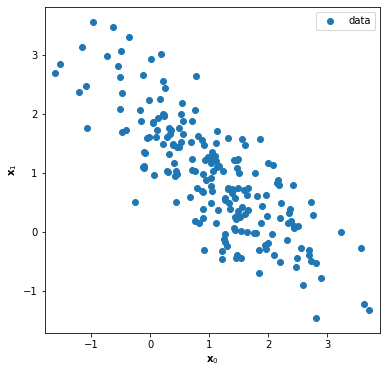

In [48]:
mvn = scipy.stats.multivariate_normal(
    mean=np.array([1, 1]), 
    cov=np.array([[1, -0.8], [-0.8, 1]])
)

# data contains 200 points generated according to the above criteria
data = mvn.rvs((200,), random_state=np.random.RandomState(0))

num_components = 1
data_reconst, mean, principal_values, principal_components = PCA(data, num_components)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(data[:, 0], data[:, 1], label='data')
plt.axis('equal')
plt.legend()
ax.set(xlabel='$\mathbf{x}_0$', ylabel='$\mathbf{x}_1$')
plt.show()

In [17]:
def draw_vector(v0, v1, ax=None, label=None):
    """Draw a vector from v0 to v1."""
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, 
                    color='k')
    ax.annotate('', v1, v0, arrowprops=arrowprops, label=label)

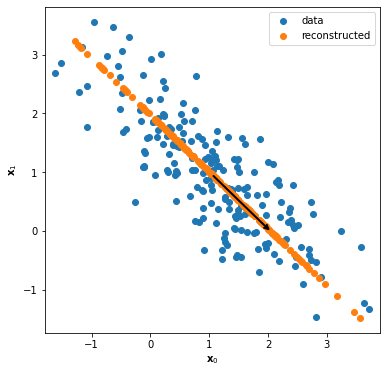

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(data[:, 0], data[:, 1], label='data')
for (princial_variance, principal_component) in (zip(principal_values, principal_components.T)):
    draw_vector(
        mean, mean + np.sqrt(princial_variance) * principal_component, 
        ax=ax)
ax.scatter(data_reconst[:, 0], data_reconst[:, 1], label='reconstructed')
plt.axis('equal')
plt.legend()
ax.set(xlabel='$\mathbf{x}_0$', ylabel='$\mathbf{x}_1$')
plt.show()

$\Box$

### Limitations

The PCA algorithm given herein is excellent for building intuition about PCA.  However, it is much less practical when compared to other implementations that use the Singular Value Decomposition (SVD).  

This is because the implementation given in this notebook does not reduce the size of the data set.  The data is projected onto a lower dimensional subspace, but still has $F$ features.  Implementations using the SVD actually reduce the size of the data set lending the reduced data set to quicker application of Machine Learning algorithms and ease in data visualization.